In [1]:
import os
import numpy as np
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import VGG19,ResNet50V2, InceptionV3, InceptionResNetV2, ConvNeXtLarge, Xception
from skimage.metrics import structural_similarity as ssim
from numpy.linalg import norm
from google.colab.patches import cv2_imshow
from sklearn.neighbors import NearestNeighbors


from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
def load_images_from_folder(folder_path):
    images = []
    num = len(os.listdir(folder_path))-1
    print(num)
    for i in range(num):
            img = cv2.imread(os.path.join(folder_path, f"ws_{i}.jpg"))
            if img is not None:
                images.append(img)
    print(len(images))
    return np.array(images)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
folder_path = "/content/drive/MyDrive/PROJECT/DATA/data_ws"

In [5]:
images = load_images_from_folder(folder_path)

1209
1209


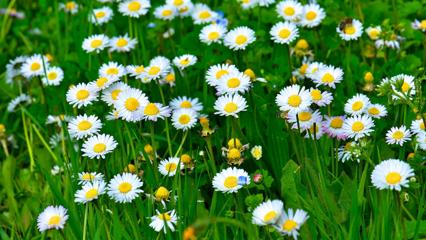

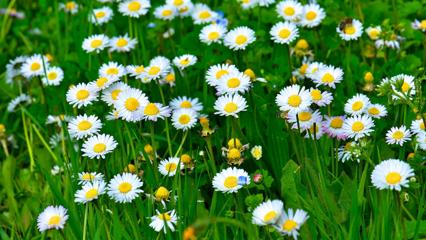

(240, 426, 3)


In [ ]:
cv2_imshow(images[1208])
img = cv2.imread("/content/drive/MyDrive/PROJECT/DATA/data_ws/ws_1208.jpg")
cv2_imshow(img)
print(images[34].shape)

# Extract features here :

In [ ]:
vgg_model = VGG19(weights='imagenet', include_top=False, input_shape=(240, 426, 3))
model_name = "VGG19"

# Extract features
features = vgg_model.predict(images)


print(features.shape)

38/38 [==============================] - 11s 284ms/step
(1209, 7, 13, 512)


In [ ]:
resnet_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(240, 426, 3))
model_name = "ResNet50V2"
features = resnet_model.predict(images)

print(features.shape)

38/38 [==============================] - 16s 238ms/step
(1209, 8, 14, 2048)


In [6]:

model_name = "InceptionV3"
ince_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(240, 426, 3))
features = ince_model.predict(images)

print(features.shape)

38/38 [==============================] - 17s 235ms/step
(1209, 6, 11, 2048)


In [ ]:

model_name = "InceptionResNetV2"
ince_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(240, 426, 3))
features = ince_model.predict(images)

print(features.shape)

38/38 [==============================] - 27s 421ms/step
(1209, 6, 11, 1536)


In [ ]:

model_name = "ConvNeXtLarge"
ince_model = ConvNeXtLarge(weights='imagenet', include_top=False, input_shape=(240, 426, 3))
features = ince_model.predict(images)

print(features.shape)

38/38 [==============================] - 88s 2s/step
(1209, 7, 13, 1536)


In [ ]:
model_name = "Xception"
ince_model = Xception(weights='imagenet', include_top=False, input_shape=(240, 426, 3))
features = ince_model.predict(images)

print(features.shape)

38/38 [==============================] - 18s 317ms/step
(1209, 8, 14, 2048)


In [ ]:

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
model_name = "Convolutional Autoencoder"
# Define the Convolutional Autoencoder architecture
input_img = Input(shape=(240, 426, 3))  # Input shape should match the image dimensions
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# This is the encoded representation of the input

# Decoder
x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# This is the reconstructed input
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


# Extract features using the CAE
features = autoencoder.predict(images)
print(features.shape)

38/38 [==============================] - 3s 68ms/step
(1209, 240, 432, 3)


# Visualize the clustering in 2D

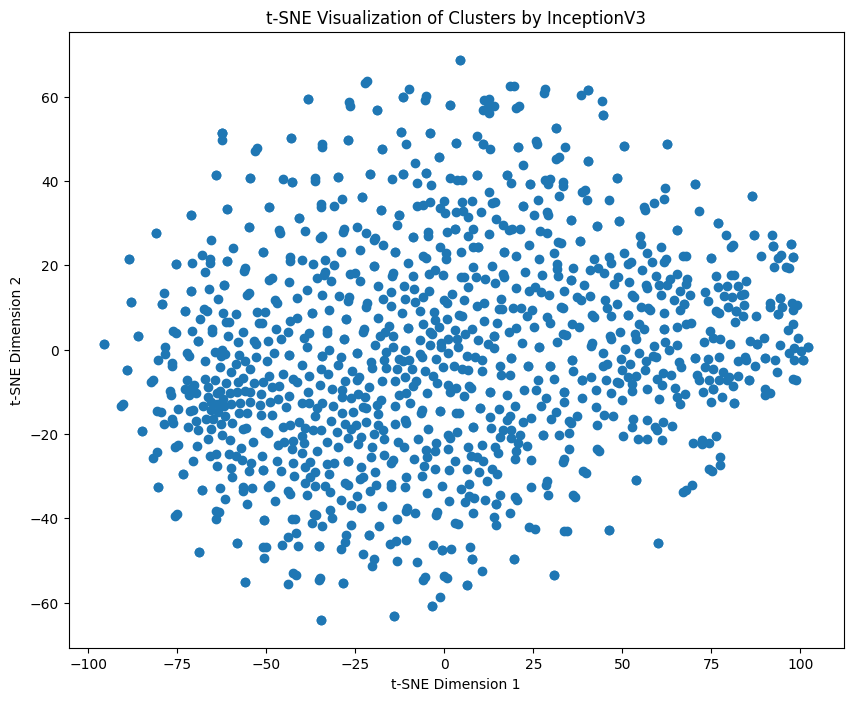

In [7]:
X = features.reshape(features.shape[0], -1)

num_clusters = 10 # You can adjust this based on your preference


# Perform dimensionality reduction with t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(X)

folder_name = f'/content/drive/MyDrive/PROJECT/GRAPH/{model_name}'
os.makedirs(folder_name, exist_ok=True)

plt.figure(figsize=(10, 8))

plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.title(f't-SNE Visualization of Clusters by {model_name}')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.savefig(f'{folder_name}/Visualization.png')
plt.show()

In [25]:
from sklearn.metrics.pairwise import cosine_similarity

# Fit KNN model
knn = NearestNeighbors(n_neighbors=num_clusters, metric='euclidean')
knn.fit(X)

# Define a function to find similar images
def find_similar_images(image_index):
    distances, indices = knn.kneighbors([X[image_index]], n_neighbors=11)

    # Find the index of the query image within the list of indices
    query_image_index = np.where(indices[0] == image_index)[0][0]

    # Remove the query image itself by index
    similar_images_indices = np.delete(indices[0], query_image_index)
    similar_images_distances = np.delete(distances[0], query_image_index)

    return similar_images_indices, similar_images_distances



# Function to plot images using indices
def compute_cosine_similarity(image1, image2):

    # Convert images to grayscale
    gray_image1 = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
    gray_image2 = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)

    # Flatten images into 1D arrays
    vector1 = gray_image1.flatten().astype(float)
    vector2 = gray_image2.flatten().astype(float)

    print(vector1.shape)
    vector1 = vector1.reshape(1, -1)
    vector2 = vector2.reshape(1, -1)
    print(vector1.shape)
    # Compute cosine similarity
    cossim = cosine_similarity(vector1,vector2)

    print(cossim[0][0])
    return cossim[0][0]



def histogram_intersection(image1, image2):
    # Compute the color histograms of the two images
    hist1 = cv2.calcHist([image1], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist2 = cv2.calcHist([image2], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])

    # Normalize the histograms
    cv2.normalize(hist1, hist1)
    cv2.normalize(hist2, hist2)

    # Compute the correlation between the two histograms
    correlation = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)

    return correlation


def compute_ssim(image1, image2):
    # Convert images to grayscale
    gray_image1 = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
    gray_image2 = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)

    # Compute SSIM
    similarity_index = ssim(gray_image1, gray_image2)

    return similarity_index

def plot_images(image_index, similar_images_indices, similarity_distances, show):
    original_image = images[image_index]


    fig = plt.figure(figsize=(15, 10))
    fig.suptitle(f'{model_name} model', fontsize=20)
    # Plot original image
    plt.subplot(3, 5, 1)
    plt.imshow(original_image[:, :, ::-1])
    plt.title(f'Original Image\nws_{image_index}.jpg')
    plt.axis('off')

    # Plot similar images
    for i, idx in enumerate(similar_images_indices):
        similar_image = images[idx]
        cossim = compute_cosine_similarity(original_image,similar_image)
        ssim = compute_ssim(original_image,similar_image)
        hist = histogram_intersection(original_image,similar_image)
        plt.subplot(3, 5, i + 6)
        plt.imshow(similar_image[:, :, ::-1])
        plt.title(f'Cosine similarity: {cossim*100:.2f}%\nStructural similarity: {ssim*100:.2f}%\nHistogram similarity: {hist*100:.2f}%\nws_{idx}.jpg')
        plt.axis('off')

    plt.tight_layout()

    if show:
      plt.show()
    else :
      plt.savefig(f'{folder_name}/CBIR_ws_{image_index}.png')
      plt.close()





# Manual Testing 🥰

(102240,)
(1, 102240)
0.9999999999999991
(102240,)
(1, 102240)
0.7581995284751221
(102240,)
(1, 102240)
0.7940475607237617
(102240,)
(1, 102240)
0.7868459195180864
(102240,)
(1, 102240)
0.7634679256982768
(102240,)
(1, 102240)
0.7408685520796225
(102240,)
(1, 102240)
0.7681545618669445
(102240,)
(1, 102240)
0.7647546785894426
(102240,)
(1, 102240)
0.7410089406428453
(102240,)
(1, 102240)
0.7594111516976705


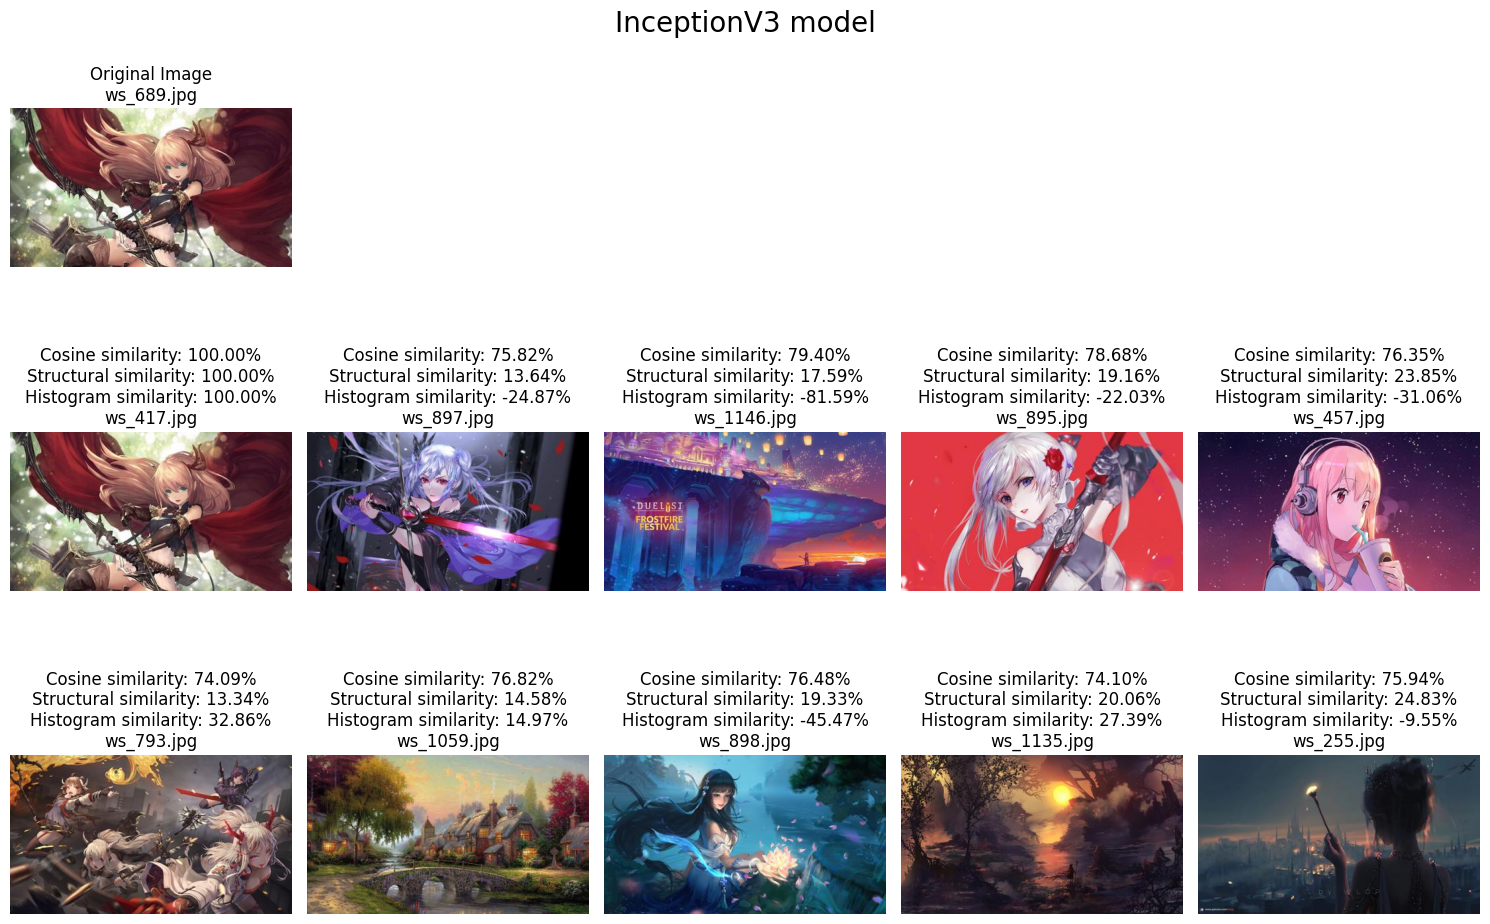

In [32]:
# Example usage
image_index = 689

similar_images_indices, similar_images_distances = find_similar_images(image_index)

# Plot images using indices
plot_images(image_index, similar_images_indices, similar_images_distances,True)
#print(compute_cosine_similarity(images[image_index],images[1083]))

In [ ]:
np.random.seed(42)


test_idx = np.random.randint(0, len(images), size=120)
print(test_idx)

[1126  860 1130 1095 1044  121  466  330   87 1123  871  130  769  343
  805  385  955  276 1184  459   21  252  747  856  474 1082  510  699
  975  189  957  686  957  562  831 1154  646   20  840  166  387  600
  315   13  241  776  564  897   91  955  508  775   34  205 1104 1025
 1021  565 1129  702  401  729  161  201  995  269  815  455 1016  295
  719  337  878 1076  791  216  763  187  379  492 1064 1180   14   64
  520 1152  647 1086 1162  592  391  418  288  378  230 1017   40 1051
  134  200  779  929 1056 1071  502  406  804   98  683  725  960  612
  642 1028  502  766  397  870  794  392]


In [ ]:
avg_cosine_similarity = []
avg_histogram_intersection = []
avg_ssim = []

for i in test_idx:
  original_image = images[i];
  similar_images_indices, _ = find_similar_images(i)
  plot_images(i, similar_images_indices, _,False)
  for idx in similar_images_indices:
        similar_image = images[idx]
        avg_cosine_similarity.append(compute_cosine_similarity(original_image,similar_image))
        avg_ssim.append(compute_ssim(original_image,similar_image))
        avg_histogram_intersection.append(histogram_intersection(original_image,similar_image))

print(f"Using {model_name} :")
print(f"Average Cosine Similarity : {np.mean(avg_cosine_similarity)*100}%")
print(f"Average Structural Similarity : {np.mean(avg_ssim)*100}%")
print(f"Average Histogram Similarity : {np.mean(avg_histogram_intersection)*100}%")


Using InceptionV3 :
Average Cosine Similarity : 81.06081007919964%
Average Structural Similarity : 26.44520594219026%
Average Histogram Similarity : 64.60352540016174%


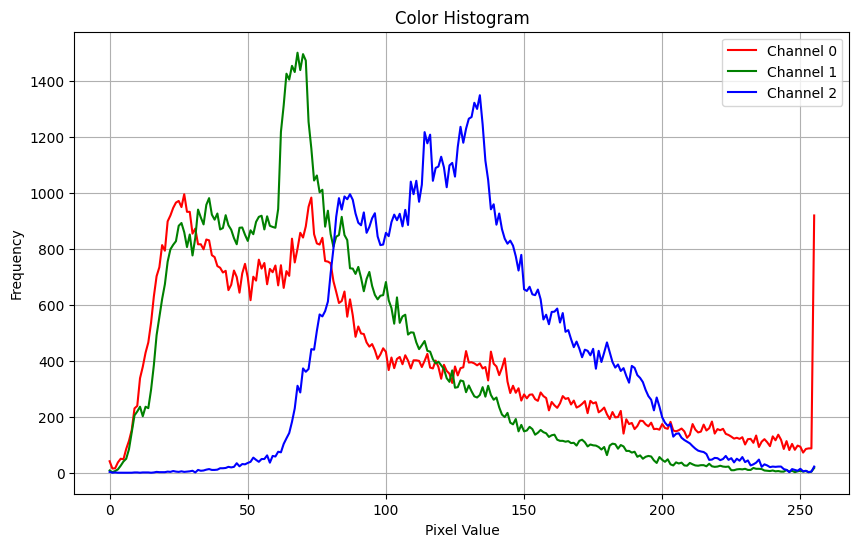

In [37]:

# Load the image
image = cv2.imread('/content/drive/MyDrive/PROJECT/DATA/data_ws/ws_1146.jpg')

# Convert the image from BGR to RGB (Matplotlib expects RGB)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Split the image into its color channels
channels = cv2.split(image_rgb)

# Initialize a list to store histograms for each channel
histograms = []

# Calculate histogram for each channel
for channel in channels:
    histogram = cv2.calcHist([channel], [0], None, [256], [0, 256])
    histograms.append(histogram)

# Plot the histograms
plt.figure(figsize=(10, 6))
plt.title('Color Histogram')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

colors = ('r', 'g', 'b')
for i, histogram in enumerate(histograms):
    plt.plot(histogram, color=colors[i], label=f'Channel {i}')

plt.legend()
plt.grid(True)
plt.show()

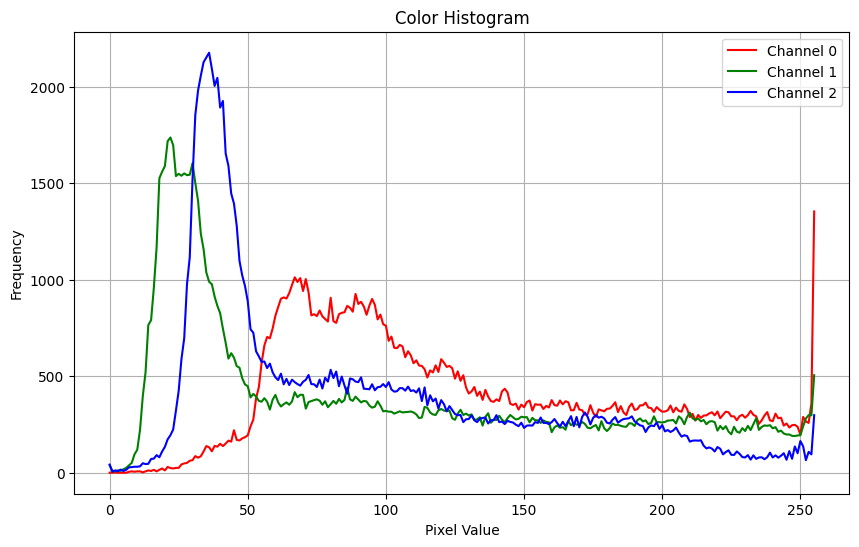

In [38]:

# Load the image
image = cv2.imread('/content/drive/MyDrive/PROJECT/DATA/data_ws/ws_689.jpg')

# Convert the image from BGR to RGB (Matplotlib expects RGB)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Split the image into its color channels
channels = cv2.split(image_rgb)

# Initialize a list to store histograms for each channel
histograms = []

# Calculate histogram for each channel
for channel in channels:
    histogram = cv2.calcHist([channel], [0], None, [256], [0, 256])
    histograms.append(histogram)

# Plot the histograms
plt.figure(figsize=(10, 6))
plt.title('Color Histogram')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

colors = ('r', 'g', 'b')
for i, histogram in enumerate(histograms):
    plt.plot(histogram, color=colors[i], label=f'Channel {i}')

plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print(len(avg_cosine_similarity))

1200
